In [1]:
from model.rnn import LSTM
from model.hidden_markov_model import HMM
from model.nn import NN
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
occupancy = pd.read_csv(r'C:\Users\ASUS\Desktop\activity inference\data\eco\home1\01_occupancy_csv\01_summer.csv',index_col=0)
# timestamps = pd.date_range(start=occupancy.index[0], end=pd.to_datetime(occupancy.index[-1])+pd.Timedelta(days=1), freq='S')


In [5]:
occupancy_state = []
for i in range(len(occupancy)):
    date = occupancy.index[i]
    timestamps = pd.date_range(start=date,end=pd.to_datetime(date)+pd.Timedelta(days=1)-pd.Timedelta(seconds=1),freq='S')
    data = occupancy.iloc[i,:]
    series = pd.DataFrame(index=timestamps, data=data.values,columns=["occupancy"]).resample('1min').max()
    occupancy_state.append(series)
occupancy_state = pd.concat(occupancy_state)

In [6]:
timestamps = occupancy_state.index

# prepare electricity

In [7]:
hdf = pd.HDFStore(r'C:\Users\ASUS\Desktop\activity inference\data\eco\eco.h5')
power_info = hdf.get('/building1/elec/meter1')
power_info.index.name = 'Date'
power_info.reset_index(inplace=True)
power_info['Date'] = pd.to_datetime(power_info['Date']).dt.tz_localize(None)
#转化时间戳
power_info.set_index('Date', drop=True, inplace=True)
power_info=power_info.fillna(0)
power_info = power_info["power"]["active"].to_frame()
power_info=power_info.resample("1min").mean()
power_info=power_info.fillna(0)
date = power_info.index.date
electricity_data = power_info.loc[np.intersect1d(pd.to_datetime(date), pd.to_datetime(timestamps))]
class Dataset:
    def __init__(self, occupancy, electricity_dat):
        self.occupancy = occupancy
        self.data = electricity_dat
num_indices = 24
sin_encoding = np.sin(2 * np.pi * electricity_data.index.hour / num_indices)
cos_encoding = np.cos(2 * np.pi * electricity_data.index.hour / num_indices)

# 将编码后的索引作为新列添加到DataFrame
electricity_data['sin_index'] = sin_encoding
electricity_data['cos_index'] = cos_encoding

,active,sin_index,cos_index
Date,,,
2012-07-15,56.373020,0.0,1.0
2012-07-16,218.112396,0.0,1.0
2012-07-17,98.080269,0.0,1.0
2012-07-18,123.346733,0.0,1.0
2012-07-20,127.024887,0.0,1.0
2012-07-21,24.764965,0.0,1.0
2012-07-22,67.322380,0.0,1.0
2012-07-23,221.355530,0.0,1.0
2012-07-24,56.647686,0.0,1.0


In [17]:
from sklearn.preprocessing import MinMaxScaler
electricity_data = MinMaxScaler().fit_transform(electricity_data)
training = 0.6
validation = 0.2
test = 0.2
validation_end = int(len(electricity_data)*validation)
training_end = validation_end + int(len(electricity_data)*training)
test_start = int(len(electricity_data)*test)
validation_dataset = Dataset(occupancy_state[:validation_end], electricity_data[:validation_end])
train_dataset = Dataset(occupancy_state[validation_end:training_end], electricity_data[validation_end:training_end])
test_dataset = Dataset(occupancy_state[-test_start:], electricity_data[-test_start:])

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [20]:
train_dataset.data


AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [19]:
test_dataset.data

array([[0.13670406, 0.        , 0.        ],
       [0.07171079, 0.        , 0.        ],
       [0.09262631, 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [0.01030707, 0.        , 0.        ],
       [0.05203364, 0.        , 0.        ],
       [0.04683405, 0.        , 0.        ]])

In [190]:
hidden_states = [5,6,7,8,9]
# score = []
# for i in hidden_states:
#     hmm = HMM(train_dataset, validation_dataset,number_of_hidden_states=i)
#     prediction = hmm.run()
#
#     from sklearn.metrics import f1_score
#     f1=f1_score(validation_dataset.occupancy, prediction)
#     score.append(f1)
hmm = HMM(train_dataset, test_dataset,number_of_hidden_states=3)
prediction = hmm.run()


In [193]:
from sklearn.metrics import f1_score
f1=f1_score(test_dataset.occupancy, prediction)
print(f1)

0.7835636722606121


<AxesSubplot:xlabel='Date'>

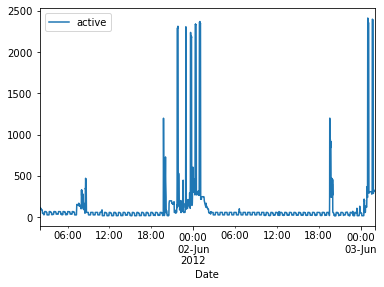

In [194]:
power_info['2012-06-01 02:00:00':'2012-06-03 02:00:00'].plot()

In [181]:
from sklearn.metrics import f1_score
f1=f1_score(test_dataset.occupancy, prediction)
print(f1)

0.7489546908562374


In [197]:
test_dataset.occupancy

,occupancy
2012-08-17 04:48:00,1
2012-08-17 04:49:00,1
2012-08-17 04:50:00,1
2012-08-17 04:51:00,1
2012-08-17 04:52:00,1
...,...
2012-08-25 23:55:00,1
2012-08-25 23:56:00,1
2012-08-25 23:57:00,1
2012-08-25 23:58:00,1


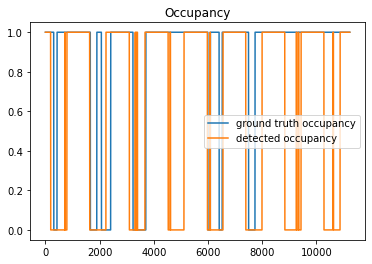

In [200]:
plt.plot(test_dataset.occupancy.values,label="ground truth occupancy")
plt.plot(prediction,label="detected occupancy")
plt.title("Occupancy")
plt.legend()
# electricity_data["2012-07-16 00:00:00":"2012-07-17 00:00:00"].plot()
# plt.title("Home-1 load profile")

NameError: name 'prediction' is not defined

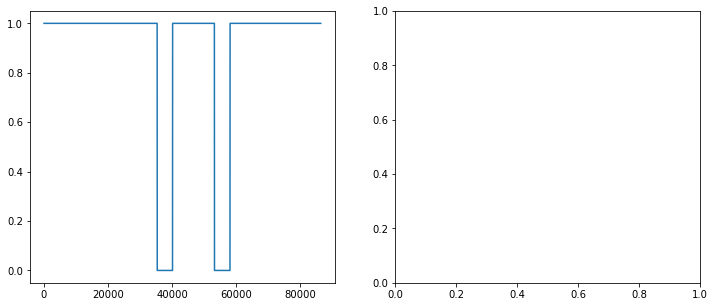

In [35]:
import matplotlib.pyplot as plt
import pandas as pd

# 创建一个包含两个子图的图形
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 第一个子图：绘制 occupancy_state 和 prediction
axes[0].plot(occupancy_state[86401:172802], label="Real")
axes[0].plot(prediction[86401:172802], label="Prediction")
axes[0].legend()

# 第二个子图：绘制 electricity_data
electricity_data["2012-07-16 00:00:00":"2012-07-17 00:00:00"].plot(ax=axes[1])

# 设置子图标题
axes[0].set_title("Occupancy State vs Prediction")
axes[1].set_title("Electricity Data")

# 调整子图布局
plt.tight_layout()

# 显示图形
plt.show()

# cross dataset

In [148]:
occupancy = pd.read_csv(r'C:\Users\ASUS\Desktop\activity inference\data\eco\home5\05_occupancy_csv\05_summer.csv',index_col=0)
# timestamps = pd.date_range(start=occupancy.index[0], end=pd.to_datetime(occupancy.index[-1])+pd.Timedelta(days=1), freq='S')
occupancy_state2 = occupancy.values.reshape(-1)
timestamps = pd.to_datetime(occupancy.index)

In [149]:
timestamps = pd.date_range(start=occupancy.index[0], end=pd.to_datetime(occupancy.index[0])+pd.Timedelta(days=1), freq='min')

In [150]:
occupancy_state2 = []
for i in range(len(occupancy)):
    date = occupancy.index[i]
    timestamps = pd.date_range(start=date,end=pd.to_datetime(date)+pd.Timedelta(days=1)-pd.Timedelta(seconds=1),freq='S')
    data = occupancy.iloc[i,:]
    series = pd.DataFrame(index=timestamps, data=data.values,columns=["occupancy"]).resample('1min').max()
    occupancy_state2.append(series)
occupancy_state2 = pd.concat(occupancy_state2)

In [151]:
len(occupancy_state2)

61920

In [152]:
timestamps = occupancy_state2.index

In [153]:
len(timestamps)

61920

In [154]:
hdf = pd.HDFStore(r'C:\Users\ASUS\Desktop\activity inference\data\eco\eco.h5')
power_info = hdf.get('/building5/elec/meter1')
power_info.index.name = 'Date'
power_info.reset_index(inplace=True)
power_info['Date'] = pd.to_datetime(power_info['Date']).dt.tz_localize(None)
#转化时间戳
power_info.set_index('Date', drop=True, inplace=True)
power_info=power_info.fillna(0)
power_info = power_info["power"]["active"].to_frame()
power_info=power_info.resample("1min").mean()
power_info=power_info.fillna(0)
date = power_info.index.date
electricity_data2 = power_info.loc[np.intersect1d(pd.to_datetime(date), pd.to_datetime(timestamps))]
class Dataset:
    def __init__(self, occupancy, electricity_dat):
        self.occupancy = occupancy
        self.data = electricity_dat
num_indices = 24
sin_encoding = np.sin(2 * np.pi * electricity_data2.index.hour / num_indices)
cos_encoding = np.cos(2 * np.pi * electricity_data2.index.hour / num_indices)

# 将编码后的索引作为新列添加到DataFrame
electricity_data2['sin_index'] = sin_encoding
electricity_data2['cos_index'] = cos_encoding

C:\Users\ASUS\AppData\Local\Temp/ipykernel_18012/2120991530.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  electricity_data2['sin_index'] = sin_encoding
C:\Users\ASUS\AppData\Local\Temp/ipykernel_18012/2120991530.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  electricity_data2['cos_index'] = cos_encoding


<AxesSubplot:xlabel='Date'>

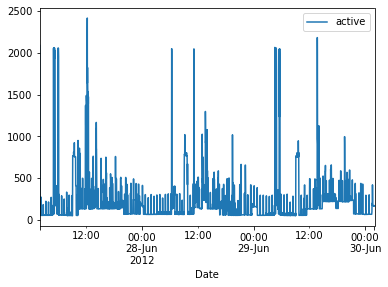

In [155]:
power_info["2012-06-27 02:00:00":"2012-06-30 02:00:00"].plot()

In [156]:
electricity_data2["active"]['2012-07-26 02:00:00':"2012-07-27 02:00:00"]

Date
2012-07-26 02:00:00    53.399849
2012-07-26 02:01:00    53.282249
2012-07-26 02:02:00    53.209152
2012-07-26 02:03:00    53.139183
2012-07-26 02:04:00    53.156498
                         ...    
2012-07-27 01:56:00    53.263882
2012-07-27 01:57:00    53.279251
2012-07-27 01:58:00    53.254086
2012-07-27 01:59:00    53.145683
2012-07-27 02:00:00    53.174236
Name: active, Length: 1441, dtype: float32

In [1]:
electricity_data2["active"]['2012-07-26 02:00:00':"2012-07-27 02:00:00"].plot()

NameError: name 'electricity_data2' is not defined

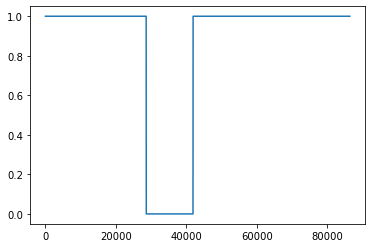

In [158]:
plt.plot(occupancy.iloc[0,:].values)

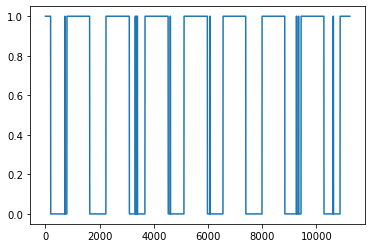

In [159]:
plt.plot(prediction[:86400])

In [160]:
from sklearn.preprocessing import MinMaxScaler
electricity_data2 = MinMaxScaler().fit_transform(electricity_data2)
test_dataset2 = Dataset(occupancy_state2, electricity_data2)
hmm = HMM(train_dataset, test_dataset2,number_of_hidden_states=3)
prediction = hmm.run()
from sklearn.metrics import f1_score
f1_score(test_dataset2.occupancy, prediction)

0.7811199866866367

In [132]:
test_dataset2.data

array([[0.04710437, 0.5       , 1.        ],
       [0.04770921, 0.5       , 1.        ],
       [0.0476707 , 0.5       , 1.        ],
       ...,
       [0.04060903, 0.37059048, 0.98296291],
       [0.04078138, 0.37059048, 0.98296291],
       [0.04078241, 0.37059048, 0.98296291]])

In [131]:
test_dataset2.occupancy

,occupancy
2012-07-24 00:00:00,1
2012-07-24 00:01:00,1
2012-07-24 00:02:00,1
2012-07-24 00:03:00,1
2012-07-24 00:04:00,1
...,...
2012-09-05 23:55:00,1
2012-09-05 23:56:00,1
2012-09-05 23:57:00,1
2012-09-05 23:58:00,1


In [119]:
f1_score(occupancy_state2, prediction)

ValueError: Found input variables with inconsistent numbers of samples: [61920, 1440]

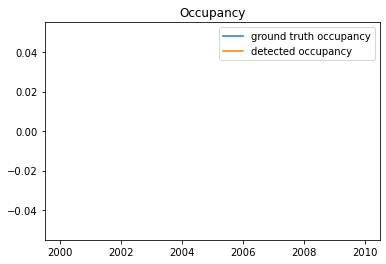

Text(0.5, 1.0, 'Home-1 load profile')

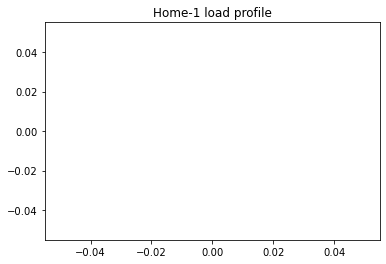

In [181]:
plt.plot(occupancy_state2[86401:172802],label="ground truth occupancy")
plt.plot(prediction[86401:172802],label="detected occupancy")
plt.title("Occupancy")
plt.legend()
plt.show()
plt.plot(electricity_data2[86401:172802])
plt.title("Home-1 load profile")

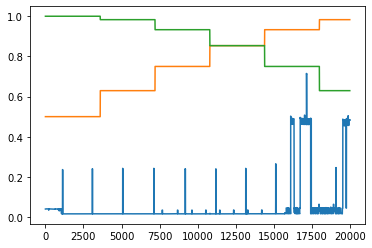

In [14]:
plt.plot(test_dataset2.data[0:20000])

In [261]:
power_info

,active
Date,
2012-06-27 02:00:00,2088.830078
2012-06-27 02:00:01,2088.879883
2012-06-27 02:00:02,2089.060059
2012-06-27 02:00:03,2089.290039
2012-06-27 02:00:04,2089.889893
...,...
2013-02-01 00:59:55,1095.839966
2013-02-01 00:59:56,1095.280029
2013-02-01 00:59:57,828.744995


In [263]:
occupancy

,'00:00:00','00:00:01','00:00:02','00:00:03','00:00:04','00:00:05','00:00:06','00:00:07','00:00:08','00:00:09',...,'23:59:50','23:59:51','23:59:52','23:59:53','23:59:54','23:59:55','23:59:56','23:59:57','23:59:58','23:59:59'
24-Jul-2012,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
25-Jul-2012,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
26-Jul-2012,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
27-Jul-2012,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
28-Jul-2012,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
29-Jul-2012,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
30-Jul-2012,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
31-Jul-2012,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
01-Aug-2012,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
02-Aug-2012,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [255]:
occupancy_state2


array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [207]:
occupancy_state2

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [203]:
prediction

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

In [212]:
occupancy.values.reshape(-1)[7200:]

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [209]:
electricity_data2

array([[0.00361788, 0.75      , 0.9330127 ],
       [0.00369869, 0.75      , 0.9330127 ],
       [0.00372587, 0.75      , 0.9330127 ],
       ...,
       [0.10303751, 0.37059048, 0.98296291],
       [0.10286682, 0.37059048, 0.98296291],
       [0.10272136, 0.37059048, 0.98296291]])

In [179]:
occupancy_state

,occupancy
2012-07-15 00:00:00,1
2012-07-15 00:01:00,1
2012-07-15 00:02:00,1
2012-07-15 00:03:00,1
2012-07-15 00:04:00,1
...,...
2012-08-25 23:55:00,1
2012-08-25 23:56:00,1
2012-08-25 23:57:00,1
2012-08-25 23:58:00,1


In [180]:
occupancy_state2["2012-07-24 00:00:00"]

,occupancy
2012-07-24 00:00:00,1
2012-07-24 00:01:00,1
2012-07-24 00:02:00,1
2012-07-24 00:03:00,1
2012-07-24 00:04:00,1
...,...
2012-09-05 23:55:00,1
2012-09-05 23:56:00,1
2012-09-05 23:57:00,1
2012-09-05 23:58:00,1


In [168]:
sum(abs(occupancy_state2.occupancy.values[:56160]-occupancy_state.occupancy.values))/56160

0.1957977207977208

<AxesSubplot:>

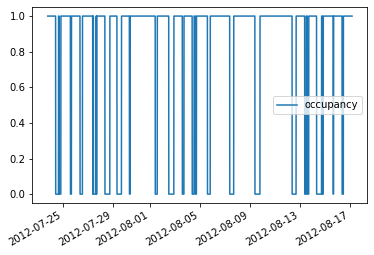

In [171]:
train_dataset.occupancy.plot()

<AxesSubplot:>

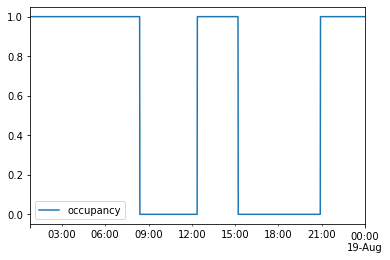

In [178]:
test_dataset.occupancy["2012-08-18 00:48:00":'2012-08-19 00:00:00'].plot()

<AxesSubplot:>

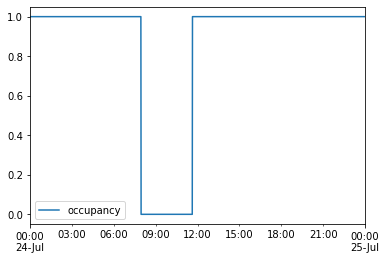

In [176]:
test_dataset2.occupancy['2012-07-24 00:00:00':'2012-07-25 00:00:00'].plot()